In [ ]:
# ============================================
# Imports & basic config
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import random_split, ConcatDataset

from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

# Use CPU (you installed CPU-only PyTorch)
device = torch.device("cpu")
print("Using device:", device)

# ====== CHANGE THIS IF DIFFERENT ======
RESULTS_ROOT = r"D:\my_projects\pmu-placement-gnn\results"
GNN_DATA_ROOT = os.path.join(RESULTS_ROOT, "gnn_dataset")
print("GNN_DATA_ROOT:", GNN_DATA_ROOT)





Using device: cpu
GNN_DATA_ROOT: D:\my_projects\pmu-placement-gnn\results\gnn_dataset


In [2]:
# %%
# ============================================
# Coverage-aware penalty term
# ============================================
import torch

def coverage_penalty(batch, logits, lambda_cov=0.3):
    """
    Differentiable surrogate for coverage.

    For each node i we approximate the probability that it is UNobserved as:
        prod_{j in {i ∪ N(i)}} (1 - p_j),

    where p_j = P(node j has a PMU).

    The penalty is the mean of these unobserved probabilities over all nodes.
    This encourages at least one high-PMU node in each 1-hop neighborhood.
    """
    # probabilities of class 1 (PMU)
    probs = F.softmax(logits, dim=-1)[:, 1]   # [N]
    one_minus_p = 1.0 - probs                 # [N]

    N = probs.size(0)
    edge_index = batch.edge_index

    # Build neighbor list on CPU (graphs are tiny, this is cheap)
    neighbors = [[] for _ in range(N)]
    src = edge_index[0].cpu().tolist()
    dst = edge_index[1].cpu().tolist()
    for u, v in zip(src, dst):
        neighbors[u].append(v)
        neighbors[v].append(u)

    per_node_unobs = []
    for i in range(N):
        idxs = [i] + neighbors[i]
        idxs_t = torch.tensor(idxs, dtype=torch.long, device=probs.device)
        prod = one_minus_p[idxs_t].prod()
        per_node_unobs.append(prod)

    per_node_unobs = torch.stack(per_node_unobs)  # [N]
    penalty = per_node_unobs.mean()
    return lambda_cov * penalty


In [3]:
# ============================================
# PMU GNN Dataset class (fixed paths + torch.load)
# ============================================

import os
import numpy as np
import pandas as pd
import torch

from torch_geometric.data import Data, InMemoryDataset


class PMUGNNDataset(InMemoryDataset):
    def __init__(self, root, index_csv, transform=None, pre_transform=None):
        """
        root: dataset directory (the folder that contains index.csv and 'samples/' folder)
        index_csv: full path to index.csv
        """
        self.index_csv = index_csv
        super().__init__(root, transform, pre_transform)

        # Load processed data (tell torch this is NOT a 'weights only' file)
        self.data, self.slices = torch.load(
            self.processed_paths[0],
            weights_only=False
        )

    @property
    def raw_file_names(self):
        # We don't actually use PyG's download mechanism, but this must exist.
        return [os.path.basename(self.index_csv)]

    @property
    def processed_file_names(self):
        return ["data.pt"]

    def download(self):
        # Nothing to download
        pass

    def process(self):
        df = pd.read_csv(self.index_csv)

        # Folder that contains index.csv (e.g. ...\IEEE14)
        base_dir = os.path.dirname(self.index_csv)

        data_list = []

        for _, row in df.iterrows():
            # 'file' column already contains something like 'samples/intact.npz'
            # So we just join it with base_dir once:
            npz_path = os.path.join(base_dir, row["file"])

            arr = np.load(npz_path, allow_pickle=True)

            # Node features
            x = torch.tensor(arr["x"], dtype=torch.float32)
            # Edge index (2 x num_edges)
            edge_index = torch.tensor(arr["edge_index"], dtype=torch.long)
            # Edge features
            edge_attr = torch.tensor(arr["edge_attr"], dtype=torch.float32)

            # Node labels: 1 if PMU at that bus, 0 otherwise
            y = torch.tensor(arr["y"], dtype=torch.long)

            # Graph-level labels (coverage, delta_pmus, etc.)
            graph_y = torch.tensor(arr["graph_y"], dtype=torch.float32)

            # Scenario type: intact / faulted
            scenario_type = str(arr["scenario_type"][0])  # stored as array of str

            data = Data(
                x=x,
                edge_index=edge_index,
                edge_attr=edge_attr,
                y=y,
            )
            data.graph_y = graph_y
            data.scenario_type = scenario_type

            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        print(f"Processed {len(data_list)} samples into {self.processed_paths[0]}")




In [4]:
# %%
# ============================================
# MULTI-RUN DATASET PATHS + LOAD + SPLIT
# ============================================
import os
from torch.utils.data import random_split, ConcatDataset
from torch_geometric.loader import DataLoader

def load_run_dataset(system_dir):
    """
    system_dir: folder that contains index.csv and the samples/ subfolder.
    Example: D:\...\results\gnn_dataset\RUN_20251124_220030_greedy_n1_14\IEEE14
    """
    index_csv = os.path.join(system_dir, "index.csv")
    if not os.path.isfile(index_csv):
        raise FileNotFoundError(f"index.csv not found for dataset at: {system_dir}")
    return PMUGNNDataset(root=system_dir, index_csv=index_csv)

# --------------------------------------------
# 1) LIST YOUR N-1 RUN DATASETS HERE
#    (copy the 'out_root_14_n1' printed from greedy notebook)
# --------------------------------------------
N1_DATASET_DIRS = [
    # Example:
    r"D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251127_182153_greedy_n1_14\IEEE14",
     r"D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251127_182728_greedy_n1_14\IEEE14",      # N-1 run 2 (optional)
]

# --------------------------------------------
# 2) LIST YOUR RANDOM-FAULT RUN DATASETS HERE
#    (copy the 'out_root_14_random' printed from greedy notebook)
# --------------------------------------------
RANDOM_DATASET_DIRS = [
    # Example:
    # RANDOM run 1
    # r"D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_2025....._greedy_random_14\IEEE14",      # RANDOM run 2 (optional)
]

print("N-1 dataset dirs:")
for p in N1_DATASET_DIRS:
    print("  ", p)
print("Random-fault dataset dirs:")
for p in RANDOM_DATASET_DIRS:
    print("  ", p)

# For compatibility with later cells (figures, model saving, etc.)
IEEE14_N1_DIR = N1_DATASET_DIRS[0]

# --------------------------------------------
# 3) LOAD ALL REQUESTED DATASETS
# --------------------------------------------
datasets = []

# Load all N-1 datasets
for path in N1_DATASET_DIRS:
    if not path:
        continue
    print(f"\n--- Loading N-1 dataset: {path} ---")
    ds = load_run_dataset(path)
    print("  Samples:", len(ds))
    datasets.append(ds)

# Load all RANDOM datasets
for path in RANDOM_DATASET_DIRS:
    if not path:
        continue
    print(f"\n--- Loading RANDOM-fault dataset: {path} ---")
    try:
        ds = load_run_dataset(path)
        print("  Samples:", len(ds))
        datasets.append(ds)
    except FileNotFoundError as e:
        print("[WARN] Random dataset not found, ignoring:", e)

if not datasets:
    raise RuntimeError("No datasets loaded. Check your paths in N1_DATASET_DIRS and RANDOM_DATASET_DIRS.")

# --------------------------------------------
# 4) MERGE INTO ONE FULL DATASET
# --------------------------------------------
if len(datasets) == 1:
    full_dataset = datasets[0]
else:
    full_dataset = ConcatDataset(datasets)

print("\nTotal graphs in full_dataset:", len(full_dataset))

# --------------------------------------------
# 5) TRAIN / VALIDATION SPLIT (80 / 20)
# --------------------------------------------
num_samples = len(full_dataset)
num_train = int(0.8 * num_samples)
num_val   = num_samples - num_train

train_dataset, val_dataset = random_split(
    full_dataset,
    [num_train, num_val],
    generator=torch.Generator().manual_seed(42)
)

print("Train graphs:", len(train_dataset))
print("Val graphs  :", len(val_dataset))

# PyG DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False)


N-1 dataset dirs:
   D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251127_182153_greedy_n1_14\IEEE14
   D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251127_182728_greedy_n1_14\IEEE14
Random-fault dataset dirs:

--- Loading N-1 dataset: D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251127_182153_greedy_n1_14\IEEE14 ---
  Samples: 21

--- Loading N-1 dataset: D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251127_182728_greedy_n1_14\IEEE14 ---
  Samples: 21

Total graphs in full_dataset: 42
Train graphs: 33
Val graphs  : 9


In [5]:
# ============================================
# Force the intact sample into the training set
# ============================================
from torch.utils.data import Subset

# Find index of intact sample in full_dataset
intact_indices = [
    i for i in range(len(full_dataset))
    if getattr(full_dataset[i], "scenario_type", None) == "intact"
]

if intact_indices:
    intact_idx = intact_indices[0]
    print("Intact sample index in full_dataset:", intact_idx)
else:
    intact_idx = None
    print("No intact sample found in full_dataset.")

if intact_idx is not None:
    # Build a new index list where intact_idx is definitely in train
    all_idx = list(range(len(full_dataset)))
    all_idx.remove(intact_idx)  # remove intact from the pool

    # Split the rest 80/20
    split = int(0.8 * len(all_idx))
    train_idx = [intact_idx] + all_idx[:split]
    val_idx   = all_idx[split:]

    train_dataset = Subset(full_dataset, train_idx)
    val_dataset   = Subset(full_dataset, val_idx)

    print("Rebuilt splits with intact sample forced into training.")
    print("Train size:", len(train_dataset), "| Val size:", len(val_dataset))

    # Rebuild DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False)


Intact sample index in full_dataset: 0
Rebuilt splits with intact sample forced into training.
Train size: 33 | Val size: 9


In [6]:
# ============================================
# Compute class weights for imbalance (0=no PMU, 1=PMU)
# ============================================
from collections import Counter

all_labels = []

# full_dataset exists from the loading cell
for i in range(len(full_dataset)):
    y_i = full_dataset[i].y
    all_labels.extend(y_i.cpu().tolist())

counts = Counter(all_labels)
num_0 = counts.get(0, 1)
num_1 = counts.get(1, 1)

print("Label counts:", counts)

# Weight class 1 (PMU) higher so the model is punished more
w0 = 1.0
w1 = num_0 / num_1  # e.g. if 0:1 ratio is 10:1, then w1=10

class_weights = torch.tensor([w0, w1], dtype=torch.float32).to(device)
print("Class weights:", class_weights)


Label counts: Counter({0: 380, 1: 208})
Class weights: tensor([1.0000, 1.8269])


In [7]:
# ============================================
# GNN model definition (simple GCN)
# ============================================
class PMUGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin   = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)  # logits per node
        return x

# Get feature dimension from one sample
sample = full_dataset[0] if isinstance(full_dataset, PMUGNNDataset) else full_dataset[0]
in_channels = sample.x.size(1)
print("Node feature dimension:", in_channels)

model = PMUGCN(in_channels=in_channels, hidden_channels=128, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)




Node feature dimension: 5


In [8]:
# %%
# ============================================
# Training and evaluation functions
# ============================================
def train_one_epoch(model, loader, optimizer, criterion, device, lambda_cov=0.3):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_nodes = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index)  # [num_nodes_in_batch, 2]

        ce_loss  = criterion(out, batch.y)
        cov_loss = coverage_penalty(batch, out, lambda_cov=lambda_cov)

        loss = ce_loss + cov_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_nodes
        preds = out.argmax(dim=-1)
        total_correct += (preds == batch.y).sum().item()
        total_nodes += batch.num_nodes

    avg_loss = total_loss / total_nodes
    acc = total_correct / total_nodes
    return avg_loss, acc


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_nodes = 0

    for batch in loader:
        batch = batch.to(device)

        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)   # validation loss: pure CE

        total_loss += loss.item() * batch.num_nodes
        preds = out.argmax(dim=-1)
        total_correct += (preds == batch.y).sum().item()
        total_nodes += batch.num_nodes

    if total_nodes == 0:
        return 0.0, 0.0

    avg_loss = total_loss / total_nodes
    acc = total_correct / total_nodes
    return avg_loss, acc


In [9]:
# %%
# ============================================
# Training loop (store curves)
# ============================================
num_epochs = 150  # you can increase later

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

best_val_acc = 0.0
best_state_dict = None

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device,
        lambda_cov=0.3,    # <--- coverage penalty weight
    )
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict()

    print(
        f"Epoch {epoch:02d} | "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
    )

print("\nBest validation accuracy:", best_val_acc)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print("Loaded best model state (based on val acc).")


Epoch 01 | Train loss: 1.1364, acc: 0.4610 | Val loss: 0.8394, acc: 0.6508
Epoch 02 | Train loss: 0.7997, acc: 0.6147 | Val loss: 0.6559, acc: 0.6508
Epoch 03 | Train loss: 0.7081, acc: 0.6558 | Val loss: 0.6328, acc: 0.5159
Epoch 04 | Train loss: 0.6792, acc: 0.6537 | Val loss: 0.6131, acc: 0.7222
Epoch 05 | Train loss: 0.6596, acc: 0.6710 | Val loss: 0.6047, acc: 0.7143
Epoch 06 | Train loss: 0.6504, acc: 0.6645 | Val loss: 0.6025, acc: 0.8175
Epoch 07 | Train loss: 0.6502, acc: 0.6970 | Val loss: 0.5887, acc: 0.7222
Epoch 08 | Train loss: 0.6377, acc: 0.6732 | Val loss: 0.5842, acc: 0.6667
Epoch 09 | Train loss: 0.6350, acc: 0.6602 | Val loss: 0.5995, acc: 0.6746
Epoch 10 | Train loss: 0.6230, acc: 0.6494 | Val loss: 0.5680, acc: 0.6667
Epoch 11 | Train loss: 0.6149, acc: 0.6494 | Val loss: 0.5621, acc: 0.6667
Epoch 12 | Train loss: 0.6183, acc: 0.6472 | Val loss: 0.5631, acc: 0.6667
Epoch 13 | Train loss: 0.6097, acc: 0.6494 | Val loss: 0.5609, acc: 0.6746
Epoch 14 | Train loss: 0.

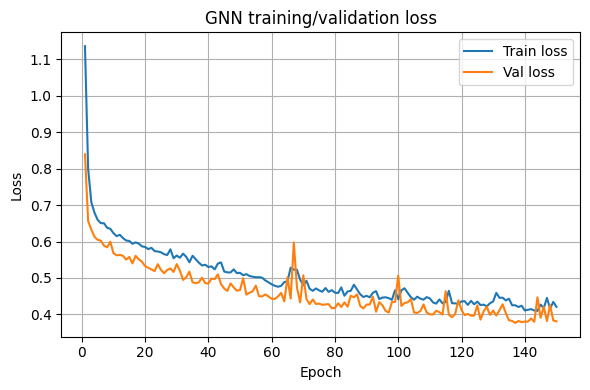

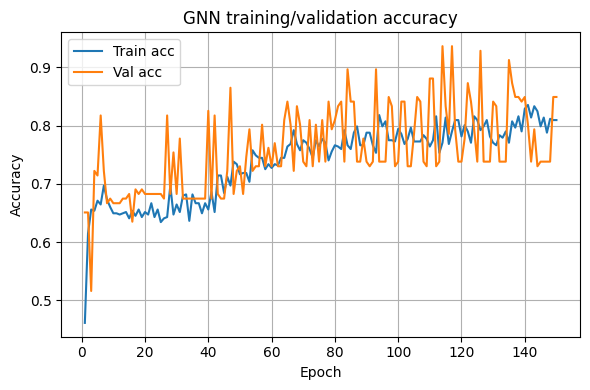

In [10]:
# ============================================
# Plot training / validation curves
# ============================================
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label="Train loss")
plt.plot(epochs, val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GNN training/validation loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_accs, label="Train acc")
plt.plot(epochs, val_accs, label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GNN training/validation accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# ============================================
# Node-level accuracy: overall, intact, faulted
# ============================================
@torch.no_grad()
def compute_node_accuracy_by_type(model, dataset, device):
    """
    Go sample-by-sample (graph-by-graph) to compute:
      - overall node accuracy
      - node accuracy on intact graphs
      - node accuracy on faulted graphs
    """
    model.eval()

    total_correct = 0
    total_nodes   = 0

    correct_intact = 0
    nodes_intact   = 0

    correct_faulted = 0
    nodes_faulted   = 0

    # dataset here is val_dataset (a Subset or ConcatDataset element)
    for i in range(len(dataset)):
        data = dataset[i]
        data = data.to(device)

        out = model(data.x, data.edge_index)
        preds = out.argmax(dim=-1)

        correct = (preds == data.y).sum().item()
        n_nodes = data.num_nodes

        total_correct += correct
        total_nodes   += n_nodes

        if data.scenario_type == "intact":
            correct_intact += correct
            nodes_intact   += n_nodes
        elif data.scenario_type == "faulted":
            correct_faulted += correct
            nodes_faulted   += n_nodes

    overall_acc   = total_correct / total_nodes if total_nodes > 0 else 0.0
    intact_acc    = correct_intact / nodes_intact if nodes_intact > 0 else 0.0
    faulted_acc   = correct_faulted / nodes_faulted if nodes_faulted > 0 else 0.0

    return overall_acc, intact_acc, faulted_acc

overall_acc, intact_acc, faulted_acc = compute_node_accuracy_by_type(model, val_dataset, device)

print("\n=== Validation accuracy (node-level) ===")
print(f"Overall  : {overall_acc*100:.2f}%")
print(f"Intact   : {intact_acc*100:.2f}%")
print(f"Faulted  : {faulted_acc*100:.2f}%")

# Make a small table for the paper
df_metrics = pd.DataFrame([{
    "Metric": "PMU accuracy (node-level)",
    "Overall (%)": overall_acc * 100,
    "Intact (%)":  intact_acc * 100,
    "Faulted (%)": faulted_acc * 100,
}])
df_metrics

table_path = os.path.join(RESULTS_ROOT, "gnn_val_metrics_IEEE14.csv")
df_metrics.to_csv(table_path, index=False)
print("Saved metrics table to:", table_path)




=== Validation accuracy (node-level) ===
Overall  : 84.92%
Intact   : 0.00%
Faulted  : 84.92%
Saved metrics table to: D:\my_projects\pmu-placement-gnn\results\gnn_val_metrics_IEEE14.csv


In [12]:
# ============================================
# Example: inspect one validation graph
# ============================================
example_graph = val_dataset[0]
example_graph = example_graph.to(device)

model.eval()
with torch.no_grad():
    out = model(example_graph.x, example_graph.edge_index)
    preds = out.argmax(dim=-1)  # 0/1 per node

pred_pmu_nodes = (preds == 1).nonzero(as_tuple=True)[0].cpu().numpy().tolist()
true_pmu_nodes = (example_graph.y == 1).nonzero(as_tuple=True)[0].cpu().numpy().tolist()

print("Scenario type:", example_graph.scenario_type)
print("Predicted PMU nodes (indices):", pred_pmu_nodes)
print("True PMU nodes (indices):     ", true_pmu_nodes)


Scenario type: faulted
Predicted PMU nodes (indices): [0, 2, 3, 5, 6, 8]
True PMU nodes (indices):      [0, 3, 5, 6, 8, 12]


Detected system name for figures: IEEE14
Saving GNN figures to: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455
Saved PNG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053455_gnn_loss_curves_IEEE14.png
Saved SVG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053455_gnn_loss_curves_IEEE14.svg
Running Inkscape for EMF export...
Saved EMF: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053455_gnn_loss_curves_IEEE14.emf


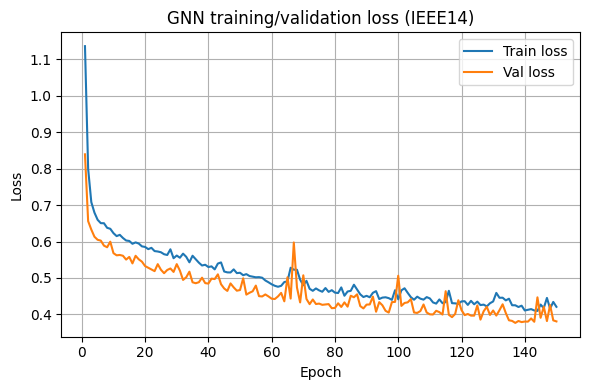

Saved PNG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053500_gnn_acc_curves_IEEE14.png
Saved SVG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053500_gnn_acc_curves_IEEE14.svg
Running Inkscape for EMF export...
Saved EMF: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053500_gnn_acc_curves_IEEE14.emf


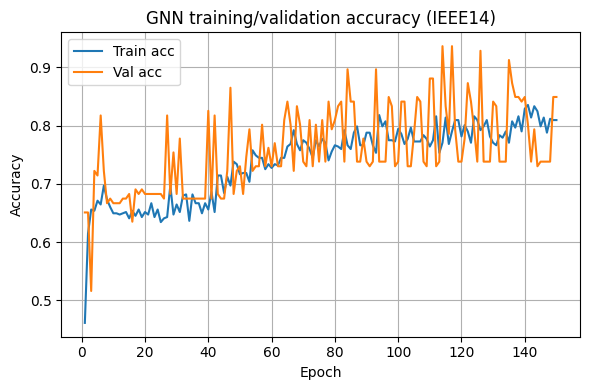

In [ ]:
# ============================================
# Save GNN training curves as PNG/SVG/EMF (auto system name)
# ============================================
import os, datetime, subprocess

# Try to infer the system name from the N-1 dataset directory
try:
    dataset_dir_for_name = IEEE14_N1_DIR   # this is what you set in the dataset paths cell
except NameError:
    # Fallback: just use GNN_DATA_ROOT if the variable name changes
    dataset_dir_for_name = GNN_DATA_ROOT

# System name = last folder name of the dataset directory (e.g. "IEEE14", "IEEE118", ...)
system_name = os.path.basename(str(dataset_dir_for_name).rstrip("/\\")) or "SYSTEM"
print("Detected system name for figures:", system_name)

# Create a unique subfolder per GNN run (timestamp-based run id)
run_id = datetime.datetime.now().strftime("GNN_%Y%m%d_%H%M%S")

# Folder for GNN figures: results/figures_gnn/<system_name>/<run_id>
gnn_fig_dir = os.path.join(RESULTS_ROOT, "figures_gnn", system_name, run_id)
os.makedirs(gnn_fig_dir, exist_ok=True)
print("Saving GNN figures to:", gnn_fig_dir)


# Inkscape config (for EMF export)
ENABLE_EMF_EXPORT = True                                      # set False if you only want PNG + SVG
INKSCAPE_EXE = r"D:\Programs\inkscape\bin\inkscape.exe"  # <-- adjust if needed


def save_gnn_fig(fig, kind):
    """
    Save a Matplotlib figure as:
      - PNG
      - SVG
      - (optionally) EMF via Inkscape

    Filenames include:
      timestamp, 'gnn', kind, and system_name
    """
    ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    base = f"{ts}_gnn_{kind}_{system_name}"

    png_path = os.path.join(gnn_fig_dir, base + ".png")
    svg_path = os.path.join(gnn_fig_dir, base + ".svg")
    emf_path = os.path.join(gnn_fig_dir, base + ".emf")

    # 1) PNG
    fig.savefig(png_path, dpi=220, bbox_inches="tight")
    print("Saved PNG:", png_path)

    # 2) SVG
    try:
        fig.savefig(svg_path, format="svg", bbox_inches="tight")
        print("Saved SVG:", svg_path)
    except Exception as e:
        print("[WARN] SVG save failed:", e)

    # 3) EMF via Inkscape 
    if ENABLE_EMF_EXPORT:
        try:
            if not os.path.isfile(INKSCAPE_EXE):
                raise FileNotFoundError(f"Inkscape not found at: {INKSCAPE_EXE}")

            cmd = [
                INKSCAPE_EXE,
                svg_path,
                "--export-type=emf",
                f"--export-filename={emf_path}",
            ]
            print("Running Inkscape for EMF export...")
            subprocess.run(cmd, check=True)
            print("Saved EMF:", emf_path)
        except Exception as e:
            print("[WARN] EMF export failed:", e)

    return png_path


# ============================================
# Re-plot and save loss & accuracy curves
# ============================================
epochs = range(1, num_epochs + 1)

# ---- Loss curves ----
fig1 = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label="Train loss")
plt.plot(epochs, val_losses,   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"GNN training/validation loss ({system_name})")
plt.legend()
plt.grid(True)
plt.tight_layout()

save_gnn_fig(fig1, "loss_curves")
plt.show()

# ---- Accuracy curves ----
fig2 = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_accs, label="Train acc")
plt.plot(epochs, val_accs,   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"GNN training/validation accuracy ({system_name})")
plt.legend()
plt.grid(True)
plt.tight_layout()

save_gnn_fig(fig2, "acc_curves")
plt.show()


In [14]:
# ============================================
# Save best trained GNN model to disk
# ============================================
import time

# System name from dataset path (e.g. "IEEE14", "IEEE118", ...)
system_name = os.path.basename(IEEE14_N1_DIR)

# Folder where all GNN models for this system will be stored
model_root = os.path.join(RESULTS_ROOT, "gnn_models", system_name)
os.makedirs(model_root, exist_ok=True)

# A short tag to remember what this model is
# (change this if you train on something else, e.g. "n1", "random", "n1_v2", etc.)
MODEL_TAG = "n1"

# Add timestamp so each training run is a different file
timestamp = time.strftime("%Y%m%d_%H%M%S")
model_filename = f"pmu_gnn_{MODEL_TAG}_{timestamp}.pth"
model_path = os.path.join(model_root, model_filename)

# If you used best_state_dict during training, save that.
# Otherwise, fall back to current model.state_dict()
if "best_state_dict" in globals() and best_state_dict is not None:
    state_to_save = best_state_dict
    print("Saving best_state_dict (best validation model).")
else:
    state_to_save = model.state_dict()
    print("best_state_dict not found; saving current model.state_dict().")

# Save weights + some useful info together
checkpoint = {
    "state_dict": state_to_save,
    "in_channels": in_channels,
    "hidden_channels": 128,   # change here if you changed the model
    "out_channels": 2,
    "system_name": system_name,
    "dataset_dir": IEEE14_N1_DIR,
    "tag": MODEL_TAG,
    "saved_at": timestamp,
}

torch.save(checkpoint, model_path)

print("\nSaved GNN checkpoint to:")
print("  ", model_path)
print("You can later reload this file and reuse the model.")


Saving best_state_dict (best validation model).

Saved GNN checkpoint to:
   D:\my_projects\pmu-placement-gnn\results\gnn_models\IEEE14\pmu_gnn_n1_20251128_053503.pth
You can later reload this file and reuse the model.


In [15]:
# ============================================
# Load a saved GNN model checkpoint (auto-latest)
# ============================================

# We infer the system name (e.g. "IEEE14") from the dataset directory:
system_name = os.path.basename(IEEE14_N1_DIR)   # already defined earlier
model_root  = os.path.join(RESULTS_ROOT, "gnn_models", system_name)

print("Looking for checkpoints in:", model_root)

if not os.path.isdir(model_root):
    raise FileNotFoundError(f"No model directory found for system '{system_name}': {model_root}")

# Collect all .pth files in that folder
model_files = [
    os.path.join(model_root, f)
    for f in os.listdir(model_root)
    if f.lower().endswith(".pth")
]

if not model_files:
    raise FileNotFoundError(f"No .pth checkpoints found in: {model_root}")

# Pick the newest checkpoint by modification time
ckpt_path = max(model_files, key=os.path.getmtime)

# Load the checkpoint
checkpoint = torch.load(ckpt_path, map_location=device)
print("\nLoaded checkpoint from:", ckpt_path)
print("  system_name:", checkpoint.get("system_name"))
print("  tag        :", checkpoint.get("tag"))
print("  saved_at   :", checkpoint.get("saved_at"))

# Rebuild the model with the same dimensions that were saved
in_channels_loaded  = checkpoint.get("in_channels")
hidden_channels     = checkpoint.get("hidden_channels", 64)
out_channels_loaded = checkpoint.get("out_channels", 2)

model = PMUGCN(
    in_channels=in_channels_loaded,
    hidden_channels=hidden_channels,
    out_channels=out_channels_loaded,
).to(device)

model.load_state_dict(checkpoint["state_dict"])
model.eval()

print("\nModel is loaded and ready for evaluation / testing.")


Looking for checkpoints in: D:\my_projects\pmu-placement-gnn\results\gnn_models\IEEE14

Loaded checkpoint from: D:\my_projects\pmu-placement-gnn\results\gnn_models\IEEE14\pmu_gnn_n1_20251128_053503.pth
  system_name: IEEE14
  tag        : n1
  saved_at   : 20251128_053503

Model is loaded and ready for evaluation / testing.


In [16]:
# ============================================
# List all saved models for this system
# ============================================
system_name = os.path.basename(IEEE14_N1_DIR)
model_root = os.path.join(RESULTS_ROOT, "gnn_models", system_name)

if not os.path.isdir(model_root):
    print("No model folder found for system:", system_name)
else:
    print("Saved models for system:", system_name)
    for fname in sorted(os.listdir(model_root)):
        print("  ", fname)


Saved models for system: IEEE14
   pmu_gnn_n1_20251125_075440.pth
   pmu_gnn_n1_20251125_081309.pth
   pmu_gnn_n1_20251125_093005.pth
   pmu_gnn_n1_20251126_025615.pth
   pmu_gnn_n1_20251126_031359.pth
   pmu_gnn_n1_20251126_040540.pth
   pmu_gnn_n1_20251127_075903.pth
   pmu_gnn_n1_20251127_081713.pth
   pmu_gnn_n1_20251127_090617.pth
   pmu_gnn_n1_20251127_183502.pth
   pmu_gnn_n1_20251127_201141.pth
   pmu_gnn_n1_20251127_201354.pth
   pmu_gnn_n1_20251127_210855.pth
   pmu_gnn_n1_20251127_212458.pth
   pmu_gnn_n1_20251127_214450.pth
   pmu_gnn_n1_20251128_032143.pth
   pmu_gnn_n1_20251128_033052.pth
   pmu_gnn_n1_20251128_033320.pth
   pmu_gnn_n1_20251128_033604.pth
   pmu_gnn_n1_20251128_045103.pth
   pmu_gnn_n1_20251128_053503.pth


Looking for checkpoints in: D:\my_projects\pmu-placement-gnn\results\gnn_models\IEEE14

--- Evaluating checkpoint: pmu_gnn_n1_20251125_075440.pth ---
  Overall acc : 72.22%
  Intact acc  : 0.00%
  Faulted acc : 72.22%

--- Evaluating checkpoint: pmu_gnn_n1_20251125_081309.pth ---
  Overall acc : 65.08%
  Intact acc  : 0.00%
  Faulted acc : 65.08%

--- Evaluating checkpoint: pmu_gnn_n1_20251125_093005.pth ---
  Overall acc : 65.08%
  Intact acc  : 0.00%
  Faulted acc : 65.08%

--- Evaluating checkpoint: pmu_gnn_n1_20251126_025615.pth ---
  Overall acc : 72.22%
  Intact acc  : 0.00%
  Faulted acc : 72.22%

--- Evaluating checkpoint: pmu_gnn_n1_20251126_031359.pth ---
  Overall acc : 65.08%
  Intact acc  : 0.00%
  Faulted acc : 65.08%

--- Evaluating checkpoint: pmu_gnn_n1_20251126_040540.pth ---
  Overall acc : 67.46%
  Intact acc  : 0.00%
  Faulted acc : 67.46%

--- Evaluating checkpoint: pmu_gnn_n1_20251127_075903.pth ---
  Overall acc : 73.02%
  Intact acc  : 0.00%
  Faulted acc : 73.

,filename,tag,saved_at,overall_acc_%,intact_acc_%,faulted_acc_%
0,pmu_gnn_n1_20251127_201354.pth,n1,20251127_201354,92.063492,0.0,92.063492
1,pmu_gnn_n1_20251127_212458.pth,n1,20251127_212458,92.063492,0.0,92.063492
2,pmu_gnn_n1_20251128_033320.pth,n1,20251128_033320,92.063492,0.0,92.063492
3,pmu_gnn_n1_20251128_045103.pth,n1,20251128_045103,88.095238,0.0,88.095238
4,pmu_gnn_n1_20251128_032143.pth,n1,20251128_032143,84.920635,0.0,84.920635
5,pmu_gnn_n1_20251128_053503.pth,n1,20251128_053503,84.920635,0.0,84.920635
6,pmu_gnn_n1_20251128_033052.pth,n1,20251128_033052,84.126984,0.0,84.126984
7,pmu_gnn_n1_20251127_183502.pth,n1,20251127_183502,84.126984,0.0,84.126984
8,pmu_gnn_n1_20251127_201141.pth,n1,20251127_201141,73.809524,0.0,73.809524
9,pmu_gnn_n1_20251127_214450.pth,n1,20251127_214450,73.809524,0.0,73.809524



Best model by overall accuracy:
filename         pmu_gnn_n1_20251127_201354.pth
tag                                          n1
saved_at                        20251127_201354
overall_acc_%                         92.063492
intact_acc_%                                0.0
faulted_acc_%                         92.063492
Name: 0, dtype: object

[GNN_FIG_DIR not defined] Showing plot only.


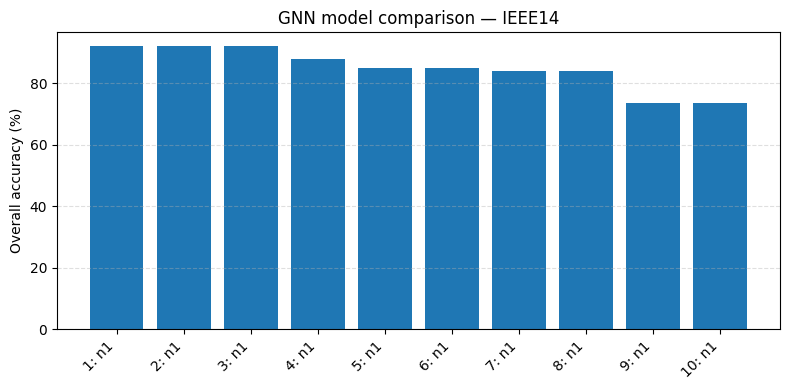

In [17]:
# ============================================
# Compare all saved GNN models + visual output
# ============================================
system_name = os.path.basename(IEEE14_N1_DIR)   # e.g. "IEEE14"
model_root  = os.path.join(RESULTS_ROOT, "gnn_models", system_name)

if not os.path.isdir(model_root):
    print("No saved models folder found for system:", system_name)
else:
    print("Looking for checkpoints in:", model_root)
    model_files = sorted([
        f for f in os.listdir(model_root)
        if f.lower().endswith(".pth")
    ])

    if not model_files:
        print("No .pth model files found in:", model_root)
    else:
        rows = []

        for fname in model_files:
            ckpt_path = os.path.join(model_root, fname)
            print(f"\n--- Evaluating checkpoint: {fname} ---")

            try:
                checkpoint = torch.load(ckpt_path, map_location=device)

                in_channels_loaded  = checkpoint.get("in_channels")
                hidden_channels     = checkpoint.get("hidden_channels", 64)
                out_channels_loaded = checkpoint.get("out_channels", 2)

                # Rebuild model with same sizes
                model_tmp = PMUGCN(
                    in_channels=in_channels_loaded,
                    hidden_channels=hidden_channels,
                    out_channels=out_channels_loaded,
                ).to(device)

                model_tmp.load_state_dict(checkpoint["state_dict"])
                model_tmp.eval()

                # Use your existing metric function
                overall_acc, intact_acc, faulted_acc = compute_node_accuracy_by_type(
                    model_tmp, val_dataset, device
                )

                rows.append({
                    "filename": fname,
                    "tag": checkpoint.get("tag", ""),
                    "saved_at": checkpoint.get("saved_at", ""),
                    "overall_acc_%": overall_acc * 100.0,
                    "intact_acc_%":  intact_acc * 100.0,
                    "faulted_acc_%": faulted_acc * 100.0,
                })

                print(f"  Overall acc : {overall_acc*100:.2f}%")
                print(f"  Intact acc  : {intact_acc*100:.2f}%")
                print(f"  Faulted acc : {faulted_acc*100:.2f}%")

            except Exception as e:
                print(f"[WARN] Could not evaluate {fname}: {e}")

        if rows:
            df_models = pd.DataFrame(rows)
            # sort by best overall accuracy
            df_models = df_models.sort_values("overall_acc_%", ascending=False).reset_index(drop=True)

            print("\n=== Summary of all evaluated models (sorted by overall_acc_%): ===")
            display(df_models)

            best = df_models.iloc[0]
            print("\nBest model by overall accuracy:")
            print(best)

            # ----------------------------------------
            # Visual output: bar chart of overall acc
            # ----------------------------------------
            top_k = min(10, len(df_models))  # show at most 10 models
            df_plot = df_models.head(top_k).copy()

            # Build labels: use tag if available, otherwise filename
            labels = []
            for i, row in df_plot.iterrows():
                if row["tag"]:
                    label = f"{i+1}: {row['tag']}"
                else:
                    label = f"{i+1}: {row['filename'].replace('.pth','')}"
                labels.append(label)

            x_pos = np.arange(len(labels))
            heights = df_plot["overall_acc_%"].values

            fig, ax = plt.subplots(figsize=(8, 4))
            ax.bar(x_pos, heights)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(labels, rotation=45, ha="right")
            ax.set_ylabel("Overall accuracy (%)")
            ax.set_title(f"GNN model comparison — {system_name}")
            ax.grid(axis="y", linestyle="--", alpha=0.4)
            fig.tight_layout()

            # Save as PNG + SVG + EMF using your existing helper
            if "GNN_FIG_DIR" in globals():
                fig_name = f"model_comparison_{system_name}.png"
                fig_path = save_fig(fig, GNN_FIG_DIR, fig_name, show_preview=True)
                print("\nSaved model comparison figure to:", fig_path)
            else:
                print("\n[GNN_FIG_DIR not defined] Showing plot only.")
                plt.show()
        else:
            print("No models were successfully evaluated.")


Using intact sample index 0 from train_dataset (scenario_type=intact)

--- Intact graph (top-K PMUs) ---
Greedy PMUs : [3, 5, 8, 0, 6]
GNN PMUs    : [0, 3, 5, 6, 8]
Coverage greedy: 100.0%  | #PMUs = 5
Coverage GNN   : 100.0%  | #PMUs = 5


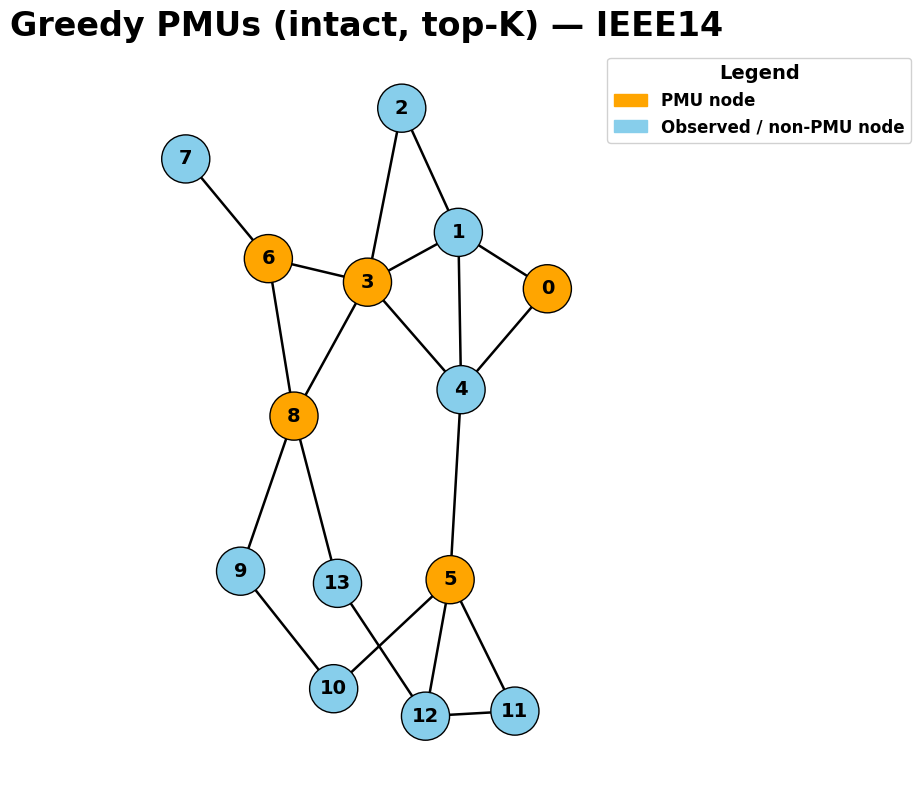

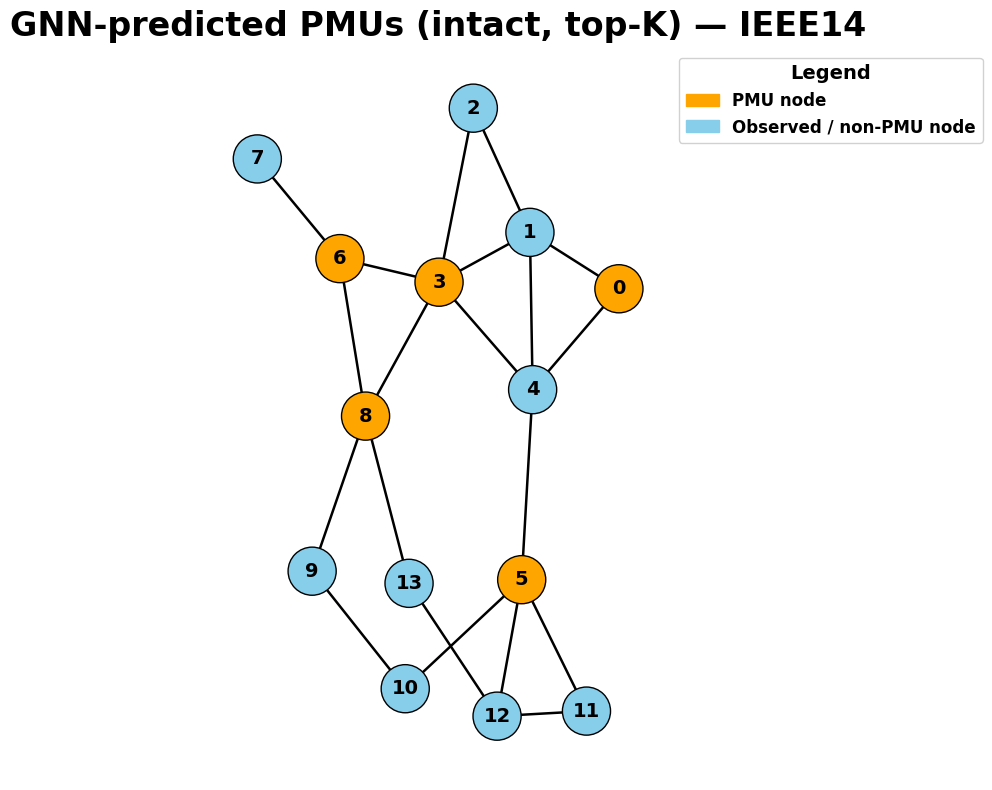

Saved PNG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053507_gnn_greedy_pmus_intact_topK_IEEE14.png
Saved SVG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053507_gnn_greedy_pmus_intact_topK_IEEE14.svg
Running Inkscape for EMF export...
Saved EMF: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053507_gnn_greedy_pmus_intact_topK_IEEE14.emf
Saved PNG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053510_gnn_gnn_pmus_intact_topK_IEEE14.png
Saved SVG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053510_gnn_gnn_pmus_intact_topK_IEEE14.svg
Running Inkscape for EMF export...
Saved EMF: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053510_gnn_gnn_pmus_intact_topK_IEEE14.emf

Saved figures to:
  greedy: D:\my_projects\pmu-placement-gnn\r

In [18]:
# ============================================
# Visual test: Greedy vs GNN on one intact graph (top-K PMUs, PNG+EMF)
# ============================================
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# ---------- Helpers: PyG -> NetworkX, greedy, coverage, plotting ----------

def pyg_to_nx_graph(data):
    """Convert a PyG Data object (edge_index) to a NetworkX Graph."""
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    edge_index = data.edge_index.cpu().numpy()
    for u, v in edge_index.T:
        u = int(u)
        v = int(v)
        if u == v:
            continue
        G.add_edge(u, v)
    return G

def observed_nodes_simple(G, pmu_nodes):
    obs = set(pmu_nodes)
    for n in pmu_nodes:
        obs.update(G.neighbors(n))
    return obs

def greedy_pmu_placement_simple(G):
    """Greedy OPP on a pure graph (no weights)."""
    all_nodes = set(G.nodes())
    pmus = []
    observed = set()
    while observed != all_nodes:
        best_node, best_gain = None, -1
        for n in all_nodes - set(pmus):
            gain = len(observed_nodes_simple(G, [n]) - observed)
            if gain > best_gain:
                best_gain, best_node = gain, n
        pmus.append(best_node)
        observed.update(observed_nodes_simple(G, [best_node]))
    return pmus



def plot_pmus(G, pmu_nodes, title, failed_edge=None):
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines

    pmu_nodes = set(pmu_nodes)
    pos = nx.kamada_kawai_layout(G)
    node_size = 1200

    pmu_color   = "orange"
    other_color = "skyblue"

    colors = [pmu_color if n in pmu_nodes else other_color for n in G.nodes()]

    # WIDER figure so the graph area can stay square even with legend space
    fig, ax = plt.subplots(figsize=(10, 8))   # was (8, 8)

    nx.draw(
        G, pos,
        with_labels=True,
        node_color=colors,
        node_size=node_size,
        edgecolors="black",
        edge_color="black",
        width=1.8,
        font_size=14,
        font_weight="bold",
        ax=ax,
    )

    # --- failed edge (same as before) ---
    failed_drawn = False
    if failed_edge is not None:
        u, v = failed_edge
        if (u in pos) and (v in pos):
            x1, y1 = pos[u]
            x2, y2 = pos[v]
            ax.plot([x1, x2], [y1, y2],
                    linewidth=6, color="red", alpha=0.9, zorder=3)
            failed_drawn = True

    legend_handles = [
        mpatches.Patch(color=pmu_color,   label="PMU node"),
        mpatches.Patch(color=other_color, label="Observed / non-PMU node"),
    ]
    if failed_drawn:
        legend_handles.append(
            mlines.Line2D([], [], color="red", linewidth=4, label="Failed branch")
        )

    leg = ax.legend(
        handles=legend_handles,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.8,
        fontsize=12,
        title="Legend",
        title_fontsize=14,
        framealpha=0.9,
    )
    for t in leg.get_texts():
        t.set_fontweight("bold")
    leg.get_title().set_fontweight("bold")

    system_name = os.path.basename(IEEE14_N1_DIR)
    ax.set_title(title + f" — {system_name}", fontsize=24, fontweight="bold")

    # keep a square-ish axes area, leave some margin for legend
    fig.tight_layout(rect=[0.0, 0.0, 0.80, 1.0])
    return fig











@torch.no_grad()
def get_gnn_topk_pmus(data, model, k):
    """
    Run GNN and select top-k nodes by P(PMU) (class 1 probability).
    This forces the GNN to use the same number of PMUs as greedy.
    """
    data = data.to(device)
    logits = model(data.x, data.edge_index)
    probs = F.softmax(logits, dim=-1)[:, 1]  # probability of class 1 = PMU

    # topk returns (values, indices)
    _, topk_idx = torch.topk(probs, k=k)
    pmu_nodes = sorted(topk_idx.cpu().numpy().tolist())
    return pmu_nodes

def find_sample_with_type(dataset, scenario_type):
    """Find first sample in 'dataset' with given scenario_type; return (idx, data) or (None, None)."""
    for i in range(len(dataset)):
        d = dataset[i]
        if getattr(d, "scenario_type", None) == scenario_type:
            return i, d
    return None, None

# ---------- Pick one intact sample (prefer val, then train, then full) ----------

intact_idx, intact = find_sample_with_type(val_dataset, "intact")
source_intact = "val_dataset"

if intact is None:
    intact_idx, intact = find_sample_with_type(train_dataset, "intact")
    source_intact = "train_dataset"
if intact is None:
    intact_idx, intact = find_sample_with_type(full_dataset, "intact")
    source_intact = "full_dataset"

if intact is None:
    raise RuntimeError("No 'intact' sample found in any dataset (val/train/full).")

system_name = os.path.basename(IEEE14_N1_DIR)
print(f"Using intact sample index {intact_idx} from {source_intact} (scenario_type={intact.scenario_type})")

# ---------- Compute greedy & GNN PMUs (top-K) ----------

G_intact = pyg_to_nx_graph(intact)

# Greedy placement on this graph
pmus_greedy_intact = greedy_pmu_placement_simple(G_intact)
K = len(pmus_greedy_intact)

# GNN placement: pick the same number K but using highest PMU probabilities
pmus_gnn_intact = get_gnn_topk_pmus(intact, model, k=K)

# Coverage for both
obs_greedy = observed_nodes_simple(G_intact, pmus_greedy_intact)
obs_gnn    = observed_nodes_simple(G_intact, pmus_gnn_intact)

cov_greedy = 100.0 * len(obs_greedy) / G_intact.number_of_nodes()
cov_gnn    = 100.0 * len(obs_gnn)    / G_intact.number_of_nodes()

print("\n--- Intact graph (top-K PMUs) ---")
print("Greedy PMUs :", pmus_greedy_intact)
print("GNN PMUs    :", pmus_gnn_intact)
print(f"Coverage greedy: {cov_greedy:.1f}%  | #PMUs = {len(pmus_greedy_intact)}")
print(f"Coverage GNN   : {cov_gnn:.1f}%  | #PMUs = {len(pmus_gnn_intact)}")

# ---------- Plot & save figures ----------

fig_greedy = plot_pmus(G_intact, pmus_greedy_intact, "Greedy PMUs (intact, top-K)")
plt.show()

fig_gnn = plot_pmus(G_intact, pmus_gnn_intact, "GNN-predicted PMUs (intact, top-K)")
plt.show()

# Save via the existing helper from the "training curves" cell, if present.
if "save_gnn_fig" in globals():
    path_greedy = save_gnn_fig(fig_greedy, "greedy_pmus_intact_topK")
    path_gnn    = save_gnn_fig(fig_gnn,    "gnn_pmus_intact_topK")
    print("\nSaved figures to:")
    print("  greedy:", path_greedy)
    print("  gnn   :", path_gnn)
else:
    print("\n[INFO] save_gnn_fig is not defined; figures were only shown, not saved.")


In [19]:
# ============================================
# Debug: coverage of greedy vs GNN (top-K) on many graphs
# ============================================
import networkx as nx
import torch.nn.functional as F

def pyg_to_nx_graph(data):
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    edge_index = data.edge_index.cpu().numpy()
    for u, v in edge_index.T:
        if u != v:
            G.add_edge(int(u), int(v))
    return G

def observed_nodes_simple(G, pmus):
    obs = set(pmus)
    for n in pmus:
        obs.update(G.neighbors(n))
    return obs

def greedy_pmu_placement_simple(G):
    all_nodes = set(G.nodes())
    pmus = []
    observed = set()
    while observed != all_nodes:
        best_node, best_gain = None, -1
        for n in all_nodes - set(pmus):
            gain = len(observed_nodes_simple(G, [n]) - observed)
            if gain > best_gain:
                best_gain, best_node = gain, n
        pmus.append(best_node)
        observed.update(observed_nodes_simple(G, [best_node]))
    return pmus

@torch.no_grad()
def gnn_topk_pmus(data, K):
    data = data.to(device)
    logits = model(data.x, data.edge_index)
    probs = F.softmax(logits, dim=-1)[:, 1]  # p(PMU)
    # indices of K largest probs
    topk = torch.topk(probs, k=K, largest=True).indices.cpu().numpy().tolist()
    return topk

def coverage_percent(G, pmus):
    obs = observed_nodes_simple(G, pmus)
    return 100.0 * len(obs) / G.number_of_nodes()

# ---------------- Run on validation set ----------------
cov_greedy_list = []
cov_gnn_list    = []
npmu_greedy_list= []

for i in range(len(val_dataset)):
    data = val_dataset[i]
    G = pyg_to_nx_graph(data)

    pmus_greedy = greedy_pmu_placement_simple(G)
    K = len(pmus_greedy)

    pmus_gnn = gnn_topk_pmus(data, K)

    cov_greedy = coverage_percent(G, pmus_greedy)
    cov_gnn    = coverage_percent(G, pmus_gnn)

    cov_greedy_list.append(cov_greedy)
    cov_gnn_list.append(cov_gnn)
    n_pmus = len(pmus_greedy)
    npmu_greedy_list.append(n_pmus)

    print(f"Graph {i:02d} | K={n_pmus} | Greedy cov={cov_greedy:.1f}% | GNN cov={cov_gnn:.1f}%")

if cov_greedy_list:
    print("\n=== Averages over validation graphs ===")
    print(f"Avg greedy coverage: {np.mean(cov_greedy_list):.2f}%")
    print(f"Avg GNN   coverage: {np.mean(cov_gnn_list):.2f}%")
    print(f"Avg greedy PMUs  K: {np.mean(npmu_greedy_list):.2f}")
else:
    print("Validation set is empty.")


Graph 00 | K=6 | Greedy cov=100.0% | GNN cov=92.9%
Graph 01 | K=5 | Greedy cov=100.0% | GNN cov=100.0%
Graph 02 | K=5 | Greedy cov=100.0% | GNN cov=100.0%
Graph 03 | K=5 | Greedy cov=100.0% | GNN cov=100.0%
Graph 04 | K=4 | Greedy cov=100.0% | GNN cov=92.9%
Graph 05 | K=4 | Greedy cov=100.0% | GNN cov=85.7%
Graph 06 | K=5 | Greedy cov=100.0% | GNN cov=100.0%
Graph 07 | K=5 | Greedy cov=100.0% | GNN cov=92.9%
Graph 08 | K=5 | Greedy cov=100.0% | GNN cov=100.0%

=== Averages over validation graphs ===
Avg greedy coverage: 100.00%
Avg GNN   coverage: 96.03%
Avg greedy PMUs  K: 4.89


Using faulted sample index 0 from val_dataset.
Detected failed branch between nodes: (8, 13)

--- Faulted graph (top-K PMUs) ---
Greedy PMUs : [3, 5, 0, 6, 8, 12]
GNN PMUs    : [8, 6, 5, 0, 3, 2]
Coverage greedy: 100.0%  | #PMUs = 6
Coverage GNN   : 92.9%  | #PMUs = 6


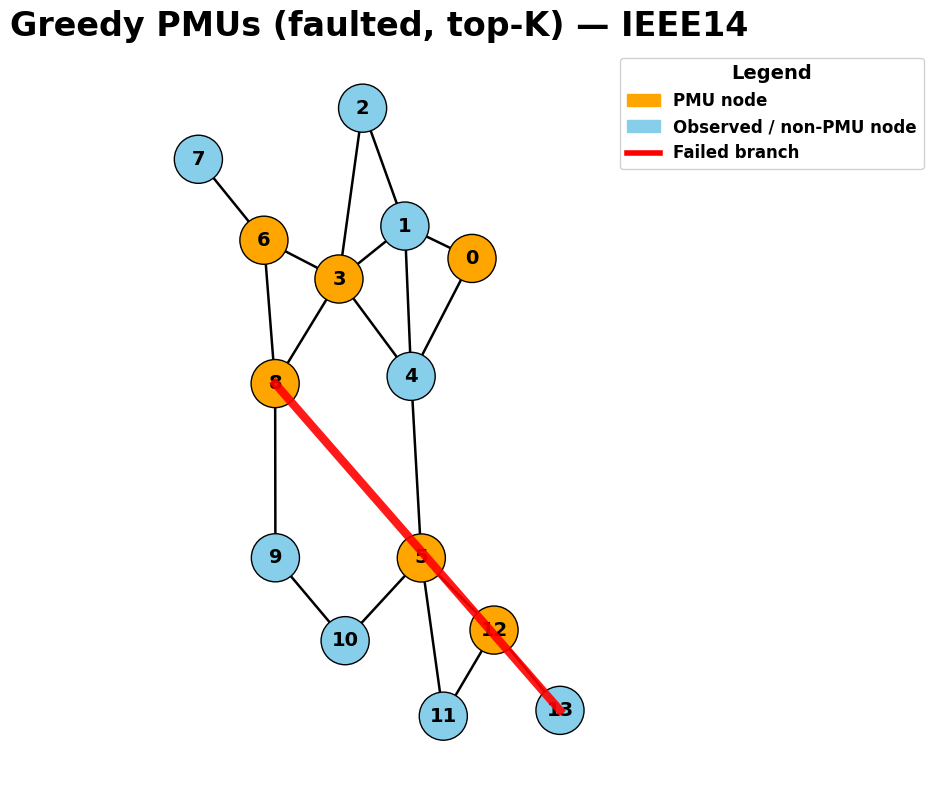

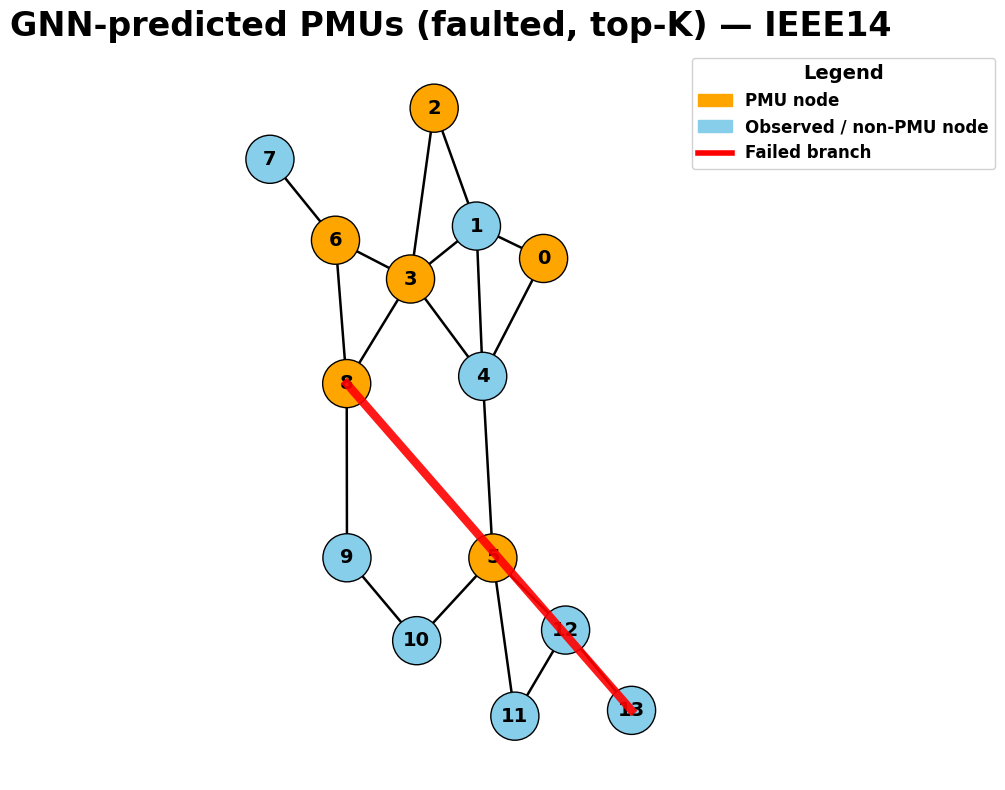

Saved PNG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053514_gnn_greedy_pmus_faulted_topK_IEEE14.png
Saved SVG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053514_gnn_greedy_pmus_faulted_topK_IEEE14.svg
Running Inkscape for EMF export...
Saved EMF: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053514_gnn_greedy_pmus_faulted_topK_IEEE14.emf
Saved PNG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053517_gnn_gnn_pmus_faulted_topK_IEEE14.png
Saved SVG: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053517_gnn_gnn_pmus_faulted_topK_IEEE14.svg
Running Inkscape for EMF export...
Saved EMF: D:\my_projects\pmu-placement-gnn\results\figures_gnn\IEEE14\GNN_20251128_053455\20251128_053517_gnn_gnn_pmus_faulted_topK_IEEE14.emf

Saved faulted figures to:
  greedy faulted: D:\my_projec

In [20]:
# %%
# ============================================
# Visual test: Greedy vs GNN on one FAULTED graph (top-K PMUs, failed branch in red)
# ============================================
import networkx as nx
import torch.nn.functional as F
import numpy as np

# We already have these from earlier cells, but just in case:
def pyg_to_nx_graph(data):
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    edge_index = data.edge_index.cpu().numpy()
    for u, v in edge_index.T:
        if u != v:
            G.add_edge(int(u), int(v))
    return G

def observed_nodes_simple(G, pmus):
    obs = set(pmus)
    for n in pmus:
        obs.update(G.neighbors(n))
    return obs

def greedy_pmu_placement_simple(G):
    all_nodes = set(G.nodes())
    pmus = []
    observed = set()
    while observed != all_nodes:
        best_node, best_gain = None, -1
        for n in all_nodes - set(pmus):
            gain = len(observed_nodes_simple(G, [n]) - observed)
            if gain > best_gain:
                best_gain, best_node = gain, n
        pmus.append(best_node)
        observed.update(observed_nodes_simple(G, [best_node]))
    return pmus

@torch.no_grad()
def gnn_topk_pmus(data, K):
    data = data.to(device)
    logits = model(data.x, data.edge_index)
    probs = F.softmax(logits, dim=-1)[:, 1]  # p(PMU)
    topk = torch.topk(probs, k=K, largest=True).indices.cpu().numpy().tolist()
    return topk

def coverage_percent(G, pmus):
    obs = observed_nodes_simple(G, pmus)
    return 100.0 * len(obs) / G.number_of_nodes()

def find_sample_with_type(dataset, scenario_type):
    for i in range(len(dataset)):
        d = dataset[i]
        if getattr(d, "scenario_type", None) == scenario_type:
            return i, d
    return None, None

# 1) Get an intact base graph (to know which edge failed)
intact_idx, intact_data = find_sample_with_type(full_dataset, "intact")
if intact_data is None:
    raise RuntimeError("No 'intact' sample found in full_dataset.")

G_intact_base = pyg_to_nx_graph(intact_data)
base_edges = {tuple(sorted(e)) for e in G_intact_base.edges()}

# 2) Pick one FAULTED sample (prefer from val_dataset)
fault_idx, fault_data = find_sample_with_type(val_dataset, "faulted")
source_fault = "val_dataset"
if fault_data is None:
    fault_idx, fault_data = find_sample_with_type(train_dataset, "faulted")
    source_fault = "train_dataset"
if fault_data is None:
    fault_idx, fault_data = find_sample_with_type(full_dataset, "faulted")
    source_fault = "full_dataset"

if fault_data is None:
    raise RuntimeError("No 'faulted' sample found in any dataset (val/train/full).")

print(f"Using faulted sample index {fault_idx} from {source_fault}.")

G_fault = pyg_to_nx_graph(fault_data)
fault_edges = {tuple(sorted(e)) for e in G_fault.edges()}

missing_edges = list(base_edges - fault_edges)
if not missing_edges:
    failed_edge = None
    print("Could not detect a missing edge (no difference from intact?).")
else:
    # For N-1 this should be exactly one
    failed_edge = missing_edges[0]
    print("Detected failed branch between nodes:", failed_edge)

# 3) Compute greedy & GNN PMUs on this faulted graph
pmus_greedy_fault = greedy_pmu_placement_simple(G_fault)
K_fault = len(pmus_greedy_fault)
pmus_gnn_fault = gnn_topk_pmus(fault_data, K_fault)

cov_greedy_fault = coverage_percent(G_fault, pmus_greedy_fault)
cov_gnn_fault    = coverage_percent(G_fault, pmus_gnn_fault)

print("\n--- Faulted graph (top-K PMUs) ---")
print("Greedy PMUs :", pmus_greedy_fault)
print("GNN PMUs    :", pmus_gnn_fault)
print(f"Coverage greedy: {cov_greedy_fault:.1f}%  | #PMUs = {len(pmus_greedy_fault)}")
print(f"Coverage GNN   : {cov_gnn_fault:.1f}%  | #PMUs = {len(pmus_gnn_fault)}")

# 4) Plot & save figures (failed branch in red on the faulted graph)
fig_greedy_faulted = plot_pmus(
    G_fault,
    pmus_greedy_fault,
    "Greedy PMUs (faulted, top-K)",
    failed_edge=failed_edge,
)
plt.show()

fig_gnn_faulted = plot_pmus(
    G_fault,
    pmus_gnn_fault,
    "GNN-predicted PMUs (faulted, top-K)",
    failed_edge=failed_edge,
)
plt.show()

# Save via helper (PNG + SVG + EMF)
if "save_gnn_fig" in globals():
    path_greedy_faulted = save_gnn_fig(fig_greedy_faulted, "greedy_pmus_faulted_topK")
    path_gnn_faulted    = save_gnn_fig(fig_gnn_faulted,    "gnn_pmus_faulted_topK")
    print("\nSaved faulted figures to:")
    print("  greedy faulted:", path_greedy_faulted)
    print("  gnn faulted   :", path_gnn_faulted)
else:
    print("\n[INFO] save_gnn_fig is not defined; faulted figures were only shown, not saved.")


In [21]:
# %%
# ============================================
# Core runtime: GNN forward on intact IEEE14
# ============================================
import time
import numpy as np
import torch

model.eval()  # inference mode

# Find one intact sample in full_dataset
intact_data = None
for i in range(len(full_dataset)):
    d = full_dataset[i]
    if getattr(d, "scenario_type", None) == "intact":
        intact_data = d
        break

if intact_data is None:
    raise RuntimeError("No intact sample with scenario_type='intact' found in full_dataset.")

intact_data = intact_data.to(device)

# Warm-up forward pass (JIT / caching / memory)
with torch.no_grad():
    _ = model(intact_data.x, intact_data.edge_index)

N = 200  # repetitions for averaging
t0 = time.perf_counter()
with torch.no_grad():
    for _ in range(N):
        _ = model(intact_data.x, intact_data.edge_index)
t1 = time.perf_counter()

avg_time_s = (t1 - t0) / N
print(f"[GNN] IEEE14 intact forward pass — avg over {N} runs: {avg_time_s*1000:.3f} ms")


[GNN] IEEE14 intact forward pass — avg over 200 runs: 1.532 ms
